## Table of Contents

2. <a href='#Introduction'>Introduction</a>


3. <a href='#Logistic Regression'>Logistic Regression</a>
    
    3.1 <a href='#clean1'>Clean data</a>

    3.2 <a href='#target and features1'>Create target and features</a>
    
    3.3 <a href='#run logistic'>Run Logistic Regression</a>
    

4. <a href='#XGBoost Classifier'>XGBoost</a>

    3.1 <a href='#clean2'>Clean data</a>

    3.2 <a href='#target and features2'>Create target and features</a>
    
    3.3 <a href='#run xgboost'>Run XGBoost</a>

## Introduction 
<a id='Introduction'></a>

25% of global suicides occur in the Western Pacific. People or organizations who care for suicide interventions would benefit from this project which seeks to predict whether school-age children will seriously consider attempting suicide or not based on other health-related survey questions they answered. Survey questions include tobacco and alcohol use, diet, relationships with parents, friends and peers. 

Logistic regression and XGboost models are shown in this notebook. Their F1 scores are similar, but XGboost performs slightly better (XGboost = .44, Logistic = .42)

## Logistic Regression
<a id='Logistic Regression'></a>

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sqlalchemy import create_engine
import psycopg2 as pg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#connecting to psql
conn = pg.connect("dbname=project3 user=karenouyang") 
cur = conn.cursor()

In [ ]:
#sql query
cur.execute('SELECT extra_infos.LDI, extra_infos.colony, country_facts.Area_km_2, "Survey".q54, "Survey".q52, "Survey".q50, "Survey".q49, "Survey".q40, "Survey".q37, "Survey".q11, "Survey".q12, "Survey".q13, "Survey".q14, "Survey".q18, "Survey".q19, "Survey".q31, "Survey".q32, "Survey".q39 , "Survey".q41, "Survey".q42, "Survey".q43, "Survey".q47, "Survey".q48, "Survey".q51, "Survey".q53, "Survey".q21, "Survey".q3, "Survey".q1, "Survey".q44, "Survey".q45, "Survey".q46, "Survey".q6, "Survey".q7, "Survey".q8, "Survey".q9, "Survey".q10, "Survey".q28, "Survey".q29, "Survey".q30, "Survey".q33, "Survey".q34, "Survey".q35, "Survey".q36, "Survey".q38, "Survey".q15, "Survey".q16, "Survey".q17, "Survey".q2, "Survey".q55, "Survey".q56, "Survey".q57, "Survey".q58, "Survey".q23, "Survey".q22, "Survey".q20, "Survey".q27, "Survey".q24, country_facts.Country, country_facts.Population, country_facts.GDP_PPP_billions, country_facts.GDP_PPP_per_capita, country_facts.GDP_nominal_billion, country_facts.GDP_nominal_per_capita, country_facts.HDI FROM "Survey" INNER JOIN country_facts ON country_facts.location = "Survey".location INNER JOIN extra_infos ON extra_infos.location = "Survey".location;')

In [ ]:
#loading query to dataframe
df2 = pd.DataFrame(cur.fetchall(), columns = ['LDI', 'colony','Area_km_2','q54', 'q52','q50', 'q49', 'q40', 'q37','q11','q12','q13','q14', 'q18', 'q19', 'q31', 'q32', 'q39', 'q41', 'q42', 'q43', 'q47', 'q48', 'q51', 'q53', 'q21', 'q3','q1', 'q44', 'q45', 'q46','q6', 'q7', 'q8', 'q9', 'q10', 'q28', 'q29', 'q30', 'q33','q34', 'q35', 'q36', 'q38','q15', 'q16', 'q17', 'q2', 'q55', 'q56', 'q57', 'q58', 'q23', 'q22', 'q20', 'q27', 'q24', 'Country', 'Population', 'GDP_PPP', 'GDP_PPP_per_capita', 'GDP_nominal', 'GDP_nominal_per_capita', 'HDI'])


### Clean the data
<a id='clean1'></a>

In [ ]:
def cleandf_logistic(df):
    df = df[df['q24'].notnull()]
    df = df.apply(pd.to_numeric, errors = 'ignore')
    df = df.fillna(df.mean())
    dummy = pd.get_dummies(df['Country'])
    df = pd.concat([df, dummy], axis=1)
    return df

In [ ]:
A1 = cleandf_logistic(df2)

### Creating our target and feature sets

<a id='target and features1'></a>

In [ ]:
#dropping some features.
X_A1 = A1.drop(['q24', 'Country', 'GDP_PPP', 'GDP_nominal', 'GDP_nominal_per_capita', 'Malaysia', 'q45', 'q7', 'q41', 'q1', 'q6', 'q48', 'Fiji', 'Cook Islands', 'Wallis and Funtuna', 'Nauru', 'q13', 'Vietnam', 'q50', 'q53', 'q49', 'q14', 'Vanuatu', 'q13'], axis=1)
#creating our target
y_A1= A1.loc[:, ['q24']]

In [ ]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_A1, y_A1, test_size = 0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=2019)

In [ ]:
#standard scaler X_train and X_test.
std_scale = StandardScaler()
X_train_scaledA = std_scale.fit_transform(X_train)
X_test_scaledA = std_scale.transform(X_test)

In [ ]:
#standard scaler X_val
X_train_val_scaledA = std_scale.fit_transform(X_val)

### Running Logistic Regression
<a id='run logistic'></a>

In [ ]:
#instantiating Logistic Regression model with class weights. Class 1 weighs 5x as much as Class 0.

lr_5x = LogisticRegression(class_weight={1 : 5, 2 : 1}, solver='liblinear', C=1)

In [ ]:
#fit model
lr_5x.fit(X_train_scaledA, y_train)

In [ ]:
print(f'The F1 score of our logistic regression model is {f1_score(y_val, lr_5x.predict(X_train_val_scaledA), pos_label=1)}.')


In [ ]:
#selecting our best p value

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = 1-lr_5x.predict_proba(X_train_val_scaledA)[:,1] 

f1_scores = []
for p in thresh_ps:
    model_val_labels =1-(model_val_probs >= p)
    f1_scores.append(f1_score(y_val-1, model_val_labels, pos_label=0))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [ ]:
y_predict = lr_5x.predict_proba(X_test_scaledA)[:,1]

In [ ]:
#create threshold for positive class.
a = y_predict >= .5

In [ ]:
b = a.astype(int)

In [ ]:
f1_score(y_test.values-1, b, pos_label=0)

In [ ]:
# create the confusion matrix.

model_confusion_lr_new = confusion_matrix(y_test.values-1, b)
plt.figure(figsize=(16, 16))
plt.subplot(3,1,1)
sns.heatmap(model_confusion_lr_new, cmap=plt.cm.Blues, annot=True, square=True,
xticklabels=['Yes', 'No'],
yticklabels=['Yes','No'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix', size=16)

In [ ]:
#get precision score
precision_score(y_test.values-1, b, pos_label=0)

In [ ]:
# get recall score
recall_score(y_test.values-1, b, pos_label=0)

In [ ]:
# get list of coefficients 
sorted((list(zip(lr_5x.coef_[0], X_train.columns))))

## XGBoost Classifier Code
<a id= 'XGBoost Classifier'></a>

In [2]:
#connecting to psql

conn = pg.connect("dbname=project3 user=karenouyang") 
cur = conn.cursor()

In [22]:
#sql query
cur.execute('SELECT extra_infos.LDI, extra_infos.colony, country_facts.Area_km_2, "Survey".q54, "Survey".q52, "Survey".q50, "Survey".q49, "Survey".q40, "Survey".q37, "Survey".q11, "Survey".q12, "Survey".q13, "Survey".q14, "Survey".q18, "Survey".q19, "Survey".q31, "Survey".q32, "Survey".q39 , "Survey".q41, "Survey".q42, "Survey".q43, "Survey".q47, "Survey".q48, "Survey".q51, "Survey".q53, "Survey".q21, "Survey".q3, "Survey".q1, "Survey".q44, "Survey".q45, "Survey".q46, "Survey".q6, "Survey".q7, "Survey".q8, "Survey".q9, "Survey".q10, "Survey".q28, "Survey".q29, "Survey".q30, "Survey".q33, "Survey".q34, "Survey".q35, "Survey".q36, "Survey".q38, "Survey".q15, "Survey".q16, "Survey".q17, "Survey".q2, "Survey".q55, "Survey".q56, "Survey".q57, "Survey".q58, "Survey".q23, "Survey".q22, "Survey".q20, "Survey".q27, "Survey".q24, country_facts.Country, country_facts.Population, country_facts.GDP_PPP_billions, country_facts.GDP_PPP_per_capita, country_facts.GDP_nominal_billion, country_facts.GDP_nominal_per_capita, country_facts.HDI FROM "Survey" INNER JOIN country_facts ON country_facts.location = "Survey".location INNER JOIN extra_infos ON extra_infos.location = "Survey".location;')

In [4]:
#loading query to dataframe
df = pd.DataFrame(cur.fetchall(), columns = ['LDI', 'colony','Area_km_2','q54', 'q52','q50', 'q49', 'q40', 'q37','q11','q12','q13','q14', 'q18', 'q19', 'q31', 'q32', 'q39', 'q41', 'q42', 'q43', 'q47', 'q48', 'q51', 'q53', 'q21', 'q3','q1', 'q44', 'q45', 'q46','q6', 'q7', 'q8', 'q9', 'q10', 'q28', 'q29', 'q30', 'q33','q34', 'q35', 'q36', 'q38','q15', 'q16', 'q17', 'q2', 'q55', 'q56', 'q57', 'q58', 'q23', 'q22', 'q20', 'q27', 'q24', 'Country', 'Population', 'GDP_PPP', 'GDP_PPP_per_capita', 'GDP_nominal', 'GDP_nominal_per_capita', 'HDI'])


### Cleaning the Data
<a id='clean2'></a>

In [5]:
def cleandf_tree(df):
    df = df[df['q24'].notnull()]
    df = df.apply(pd.to_numeric, errors = 'ignore')
    df = df.fillna(-999)
    dummy = pd.get_dummies(df['Country'])
    df = pd.concat([df, dummy], axis=1)
    return df

In [7]:
A = cleandf_tree(df)

### Creating our Feature/Target Sets
<a id='target and features2'></a>

In [8]:
#dropping some features
X_A = A.drop(['q24', 'Country', 'GDP_PPP', 'GDP_nominal', 'GDP_nominal_per_capita'], axis=1)
#setting our target
y_A = A.loc[:, ['q24']]

In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_A, y_A, test_size = 0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=2019)

### Running XGBoost
<a id='run xgboost'></a>

In [10]:
gbm = xgb.XGBRegressor( 
                       n_estimators=1000, 
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8,
                      )

eval_set=[(X_train,y_train.values-1),(X_val,y_val.values-1)]
fit_model = gbm.fit( 
                    X_train, y_train.values-1, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False
                   )

In [11]:
y_predict = gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit) 

Logistic Regression Model best F1 score 0.428 at prob decision threshold >= 0.186


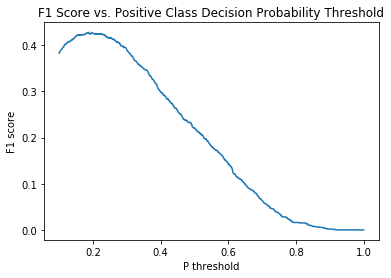

In [33]:
#selecting the best p threshold

thresh_ps = np.linspace(.10,1,1000)
model_val_probs = 1-y_predict 

f1_scores = []
for p in thresh_ps:
    model_val_labels = 1-(model_val_probs >= p)
    f1_scores.append(f1_score(y_val-1, model_val_labels, pos_label=0))
    
plt.plot(thresh_ps, f1_scores)
plt.title('F1 Score vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('F1 score')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [13]:
y_predict_new = gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)

In [14]:
# setting our threshold for the positive class.
a = y_predict_new >= .814

In [15]:
b = a.astype(int)

In [16]:
f1_score(y_test.values-1, b, pos_label=0)

0.4406202723146747

Text(0.5, 1, 'XGBoost confusion matrix')

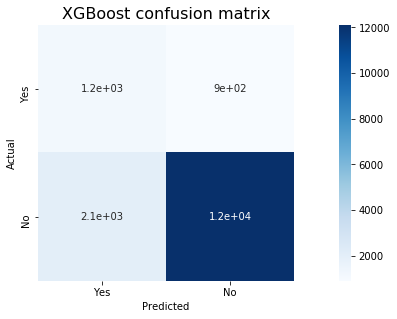

In [17]:
# creating our confusion matrix
model_confusion_xg_new = confusion_matrix(y_test.values-1, b)
plt.figure(figsize=(16, 16))
plt.subplot(3,1,1)
sns.heatmap(model_confusion_xg_new, cmap=plt.cm.Blues, annot=True, square=True,
xticklabels=['Yes', 'No'],
yticklabels=['Yes','No'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix', size=16)

In [18]:
#getting precision score
precision_score(y_test.values-1, b, pos_label=0)

0.3616889164855635

In [19]:
#getting recall score
recall_score(y_test.values-1, b, pos_label=0) 

0.563618771165941

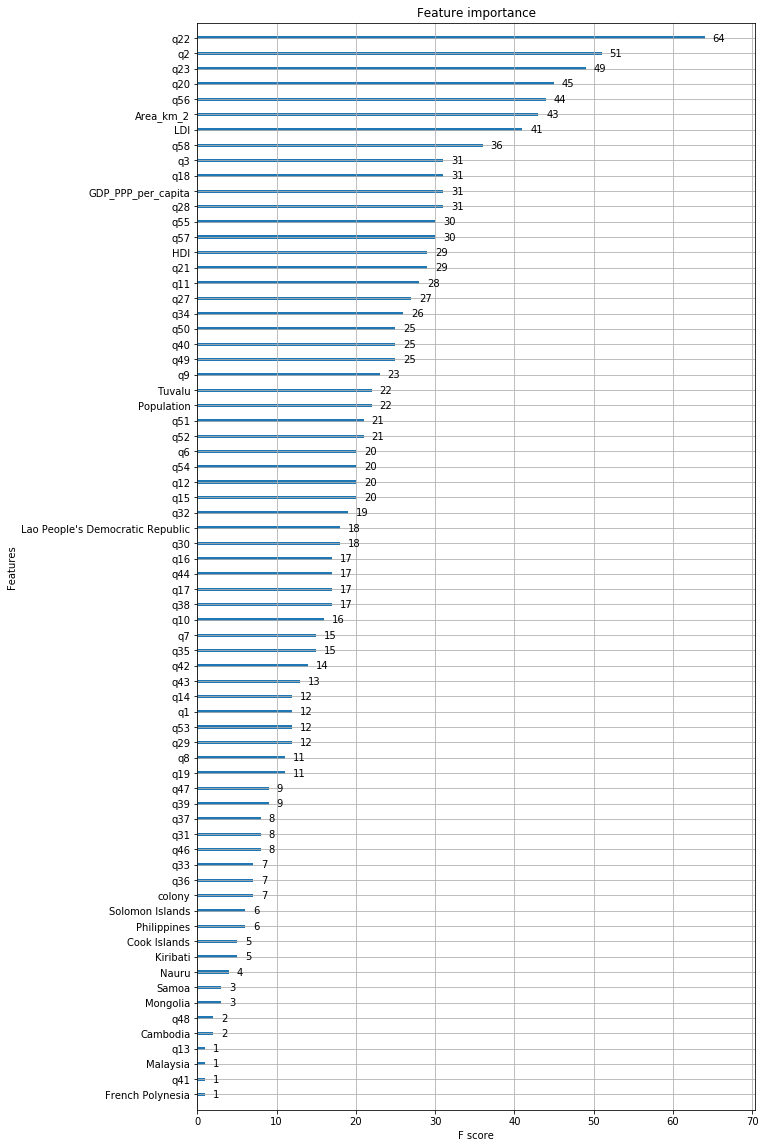

In [20]:
#plotting feature importance
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(gbm, ax=ax)

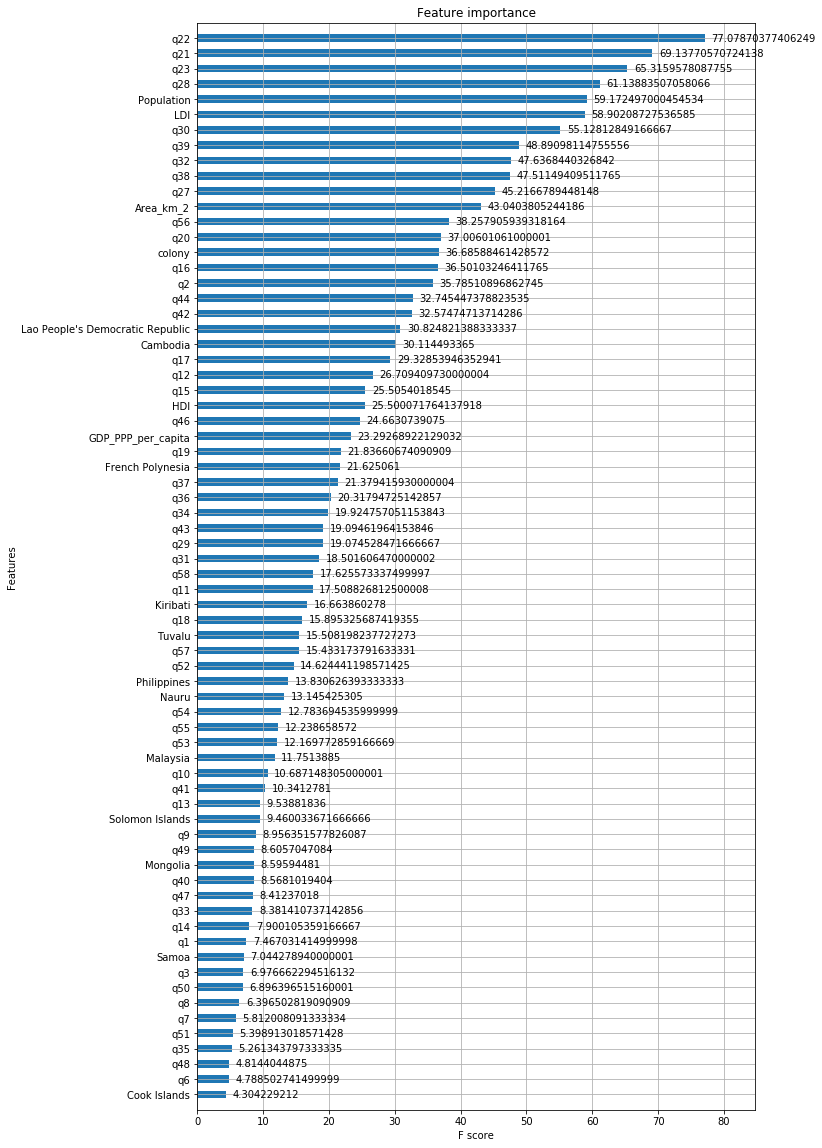

In [21]:
#plotting feature importance in gains.

fig, ax = plt.subplots(figsize=(10, 20))

xgb.plot_importance(gbm, importance_type='gain',height= .5, ax=ax)